# Pandas Data Analysis Example Lab
> By Jason Bedford (http://jbedford.net/)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('./data/cdystonia.csv')

In [17]:
df.drop('id', axis=1 ,inplace=True)

In [18]:
df.head()

,patient,obs,week,site,treat,age,sex,twstrs
0,1,1,0,1,5000U,65,F,32
1,1,2,2,1,5000U,65,F,30
2,1,3,4,1,5000U,65,F,24
3,1,4,8,1,5000U,65,F,37
4,1,5,12,1,5000U,65,F,39


These data are from Statistical Methods for the Analysis of Repeated Measurements by Charles S. Davis, pp. 161-163 (Springer, 2002). These data are from a multicenter, randomized controlled trial of botulinum toxin type B (BotB) in patients with cervical dystonia from nine U.S. sites.

* "treat" tells us what the patient received. 5000 units of BotB 10,000 units of BotB or placebo.

* "twstrs" tells us  total score on Toronto Western Spasmodic Torticollis Rating Scale (TWSTRS), measuring severity, pain, and disability of cervical dystonia (high scores mean more impairment)

* The other columns are straightforward. Note that some patients missed weeks.



## Restructuring DataFrame objects

The first thing that we noticed is that twstrs is unique. so a single patient appears in man rows. These is nothing inherently wrong with structuring the dataset this but it does make certain types of analysis more difficult. What other ways could we structure this dataset? 

The answer is that we could make each patent a single row. which would mean that we could have have columns for each of the weeks of the twstrs scores. This can be accomplished with a simple pivot.

In [20]:
df_wide = df.pivot(index='patient', columns='obs', values='twstrs')

In [22]:
df_wide.head()

obs,1,2,3,4,5,6
patient,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0
2,60.0,26.0,27.0,41.0,65.0,67.0
3,44.0,20.0,23.0,26.0,35.0,35.0
4,53.0,61.0,64.0,62.0,NaN,NaN
5,53.0,35.0,48.0,49.0,41.0,51.0


and we can add the site, treat, age, sex information.

In [41]:
df_wide_full = pd.merge(df_wide,df.set_index('patient')\
                        [['site','treat','age','sex']].drop_duplicates(),\
         left_index=True, right_index=True, how='left')

In [42]:
df_wide_full.head()

,1,2,3,4,5,6,site,treat,age,sex
patient,,,,,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0,1.0,5000U,65.0,F
2,60.0,26.0,27.0,41.0,65.0,67.0,1.0,10000U,70.0,F
3,44.0,20.0,23.0,26.0,35.0,35.0,1.0,5000U,64.0,F
4,53.0,61.0,64.0,62.0,NaN,NaN,1.0,Placebo,59.0,F
5,53.0,35.0,48.0,49.0,41.0,51.0,1.0,10000U,76.0,F


This illustrates the two formats for longitudinal data: **long** and **wide** formats. Its typically better to store data in long format because additional data can be included as additional rows in the database, while wide format requires that the entire database schema be altered by adding columns to every row as data are collected.

The preferable format for analysis depends entirely on what is planned for the data, so it is important to be able to move easily between them.

## Data aggregation and GroupBy operations

After getting familiar with the data and the two ways we can structure it we might want to start asking questions. For example, is there any change in twstrs for the different treat. We can figure this out using groupby.

In [48]:
df.groupby('treat')['twstrs'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
10000U,213.0,41.563380,12.546215,9.0,33.0,44.0,51.0,67.0
5000U,211.0,41.364929,13.531779,7.0,32.0,43.0,51.0,71.0
Placebo,207.0,41.507246,12.078573,6.0,33.0,43.0,50.5,71.0


Does not look like much of difference but let's also look at some other features. We could use a statistical significance test but it’s just going to tell us what we can see from glancing at the data. 

In [49]:
df.groupby('treat')[['twstrs', 'age']].mean()

,twstrs,age
treat,,
10000U,41.563380,55.774648
5000U,41.364929,56.957346
Placebo,41.507246,54.086957


Same story

We can look at discrete variables with value counts.

In [51]:
df.groupby('treat')['sex'].value_counts().unstack()

sex,F,M
treat,,
10000U,165,48
5000U,106,105
Placebo,124,83


seems to be some sex imbalance in the 10kU group

As I was saying the wide structure of our data can be useful. Specifically, if we wanted to know how twstrs changes over time for the different treat classes.

In [58]:
df_wide_full.groupby('treat')[[1, 2, 3, 4, 5, 6]].mean()

,1,2,3,4,5,6
treat,,,,,,
10000U,47.055556,36.628571,35.542857,39.393939,44.939394,49.342857
5000U,46.228571,37.000000,37.114286,39.676471,43.114286,44.735294
Placebo,43.583333,39.969697,39.342857,41.400000,41.735294,42.911765


This is a lot of data it would be nice if we could view this as a plot.

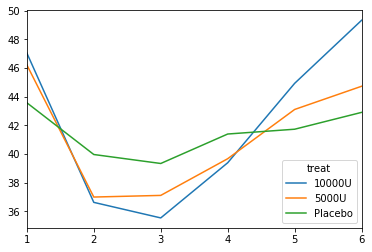

In [60]:
df_wide_full.groupby('treat')[[1, 2, 3, 4, 5, 6]].mean().T.plot()

The treatment seems to be taking a while might be worth it to continue the study a few more weeks.

Finally, we can see if patents at different hospitals were more likely to receive the treatment or a placebo. Note this could influence the results.

In [62]:
df.groupby('site')['treat'].value_counts().unstack()

treat,10000U,5000U,Placebo
site,,,
1,24,24,22
2,23,29,30
3,24,24,24
4,18,12,18
5,11,11,11
6,27,30,30
7,24,24,24
8,41,35,30
9,21,22,18


since this is a lot of dat we can plot it like this.

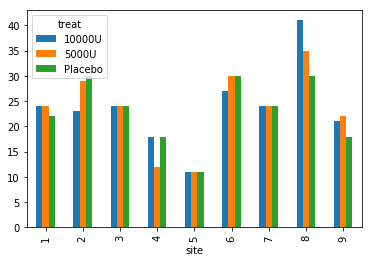

In [63]:
df.groupby('site')['treat'].value_counts().unstack().plot(kind='bar')

And that wraps up our analysis. Different ways to structure the data useful for different types of analysis.